In [2]:
# Gerekli kütüphaneleri import et
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd

# Spark oturumu oluştur
spark = SparkSession.builder \
    .appName("ClimateWatch") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# NASA sıcaklık verilerini yükle
temp_df = spark.read.csv("/home/jovyan/data_storage/climate/nasa_temperature.csv", 
                        header=True, 
                        inferSchema=True)

# NOAA CO2 verilerini yükle
co2_df = spark.read.csv("/home/jovyan/data_storage/climate/noaa_co2.csv", 
                       header=True, 
                       inferSchema=True)

# GDELT haber verilerini yükle
news_df = spark.read.csv("/home/jovyan/data_storage/news/*.csv", 
                        header=True, 
                        inferSchema=True)

# Veri setlerinin şemalarını kontrol et
print("NASA Sıcaklık Verisi Şeması:")
temp_df.printSchema()

print("\nNOAA CO2 Verisi Şeması:")
co2_df.printSchema()

print("\nGDELT Haber Verisi Şeması:")
news_df.printSchema()

# İlk birkaç satırı göster
print("\nNASA Sıcaklık Verisi Örneği:")
temp_df.show(5)

print("\nNOAA CO2 Verisi Örneği:")
co2_df.show(5)

print("\nGDELT Haber Verisi Örneği:")
news_df.show(5)

NASA Sıcaklık Verisi Şeması:
root
 |-- Year: integer (nullable = true)
 |-- Temperature_Anomaly: double (nullable = true)


NOAA CO2 Verisi Şeması:
root
 |-- Year: integer (nullable = true)
 |-- CO2: double (nullable = true)


GDELT Haber Verisi Şeması:
root
 |-- date: timestamp (nullable = true)
 |-- article_count: integer (nullable = true)
 |-- avg_tone: double (nullable = true)


NASA Sıcaklık Verisi Örneği:
+----+-------------------+
|Year|Temperature_Anomaly|
+----+-------------------+
|1880|              -17.0|
|1881|               -9.0|
|1882|              -11.0|
|1883|              -18.0|
|1884|              -29.0|
+----+-------------------+
only showing top 5 rows


NOAA CO2 Verisi Örneği:
+----+------+
|Year|   CO2|
+----+------+
|1970|325.68|
|1971|326.32|
|1972|327.46|
|1973|329.68|
|1974|330.19|
+----+------+
only showing top 5 rows


GDELT Haber Verisi Örneği:
+--------------------+-------------+--------+
|                date|article_count|avg_tone|
+--------------------

İklim Verisi İstatistikleri:
+-------+------------------+-------------------+-----------------+
|summary|              Year|Temperature_Anomaly|              CO2|
+-------+------------------+-------------------+-----------------+
|  count|                55|                 55|               55|
|   mean|            1997.0|  46.96363636363636|368.3203636363636|
| stddev|16.020819787597222|   33.5376867266726|29.00673950829979|
|    min|              1970|              -10.0|           325.68|
|    max|              2024|              129.0|           424.61|
+-------+------------------+-------------------+-----------------+


Sıcaklık ve CO2 Korelasyonu:
+------------------+
|       correlation|
+------------------+
|0.9594724522370547|
+------------------+


Yıllık Ortalama Değerler:
+----+---------------+-------+
|Year|avg_temperature|avg_co2|
+----+---------------+-------+
|1970|            3.0| 325.68|
|1971|           -8.0| 326.32|
|1972|            1.0| 327.46|
|1973|           1

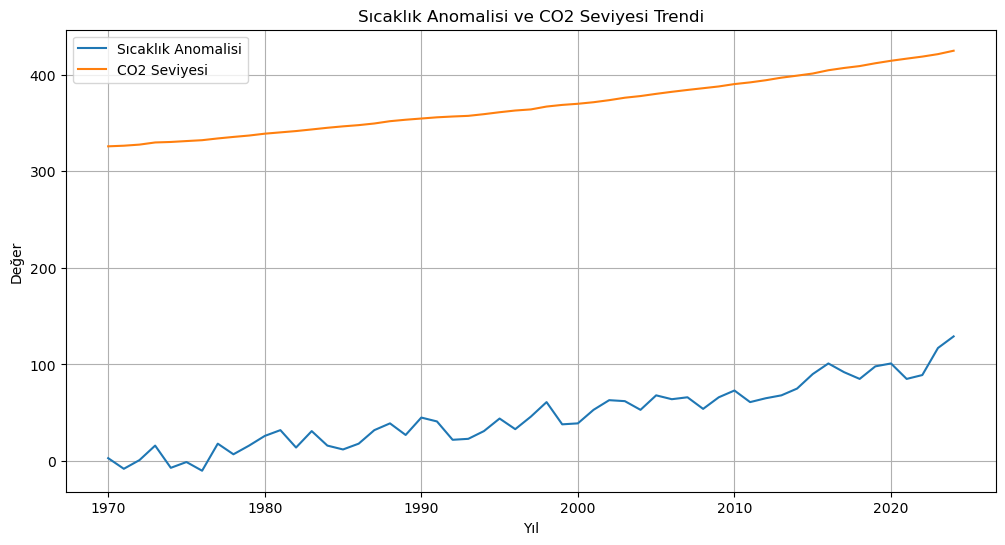

In [4]:
# Sıcaklık ve CO2 verilerini birleştir
climate_df = temp_df.join(co2_df, on="Year", how="inner")

# Yıllara göre sırala
climate_df = climate_df.orderBy("Year")

# İstatistiksel analiz
print("İklim Verisi İstatistikleri:")
climate_df.describe().show()

# Korelasyon analizi
print("\nSıcaklık ve CO2 Korelasyonu:")
climate_df.select(
    corr("Temperature_Anomaly", "CO2").alias("correlation")
).show()

# Trend analizi için yıllık ortalama değerler
print("\nYıllık Ortalama Değerler:")
climate_df.groupBy("Year").agg(
    avg("Temperature_Anomaly").alias("avg_temperature"),
    avg("CO2").alias("avg_co2")
).orderBy("Year").show(10)

# Son 10 yılın analizi
print("\nSon 10 Yılın Analizi:")
climate_df.filter(col("Year") >= 2014).orderBy("Year").show()

# Görselleştirme için pandas DataFrame'e dönüştür
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi pandas'a dönüştür
climate_pd = climate_df.toPandas()

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(climate_pd['Year'], climate_pd['Temperature_Anomaly'], label='Sıcaklık Anomalisi')
plt.plot(climate_pd['Year'], climate_pd['CO2'], label='CO2 Seviyesi')
plt.xlabel('Yıl')
plt.ylabel('Değer')
plt.title('Sıcaklık Anomalisi ve CO2 Seviyesi Trendi')
plt.legend()
plt.grid(True)
plt.show()

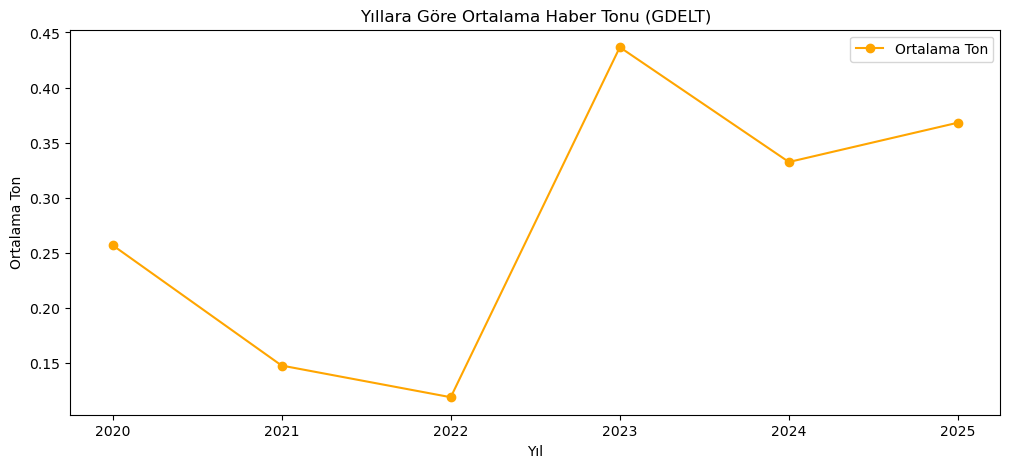

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [16]:
news_yearly = news_df.withColumn("Year", year("date")) \
    .groupBy("Year") \
    .agg(
        sum("article_count").alias("total_articles"),
        avg("avg_tone").alias("avg_tone")
    ) \
    .orderBy("Year")

# Pandas'a çevir
news_pd = news_yearly.toPandas()

# Görselleştir
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(news_pd['Year'], news_pd['avg_tone'], marker='o', color='orange', label='Ortalama Ton')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Ton')
plt.title('Yıllara Göre Ortalama Haber Tonu (GDELT)')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))

                         Year  Temperature_Anomaly       CO2  total_articles  \
Year                 1.000000             0.746729  0.993933        0.809283   
Temperature_Anomaly  0.746729             1.000000  0.787948        0.305910   
CO2                  0.993933             0.787948  1.000000        0.740973   
total_articles       0.809283             0.305910  0.740973        1.000000   
avg_tone             0.529747             0.855061  0.538217        0.278358   

                     avg_tone  
Year                 0.529747  
Temperature_Anomaly  0.855061  
CO2                  0.538217  
total_articles       0.278358  
avg_tone             1.000000  


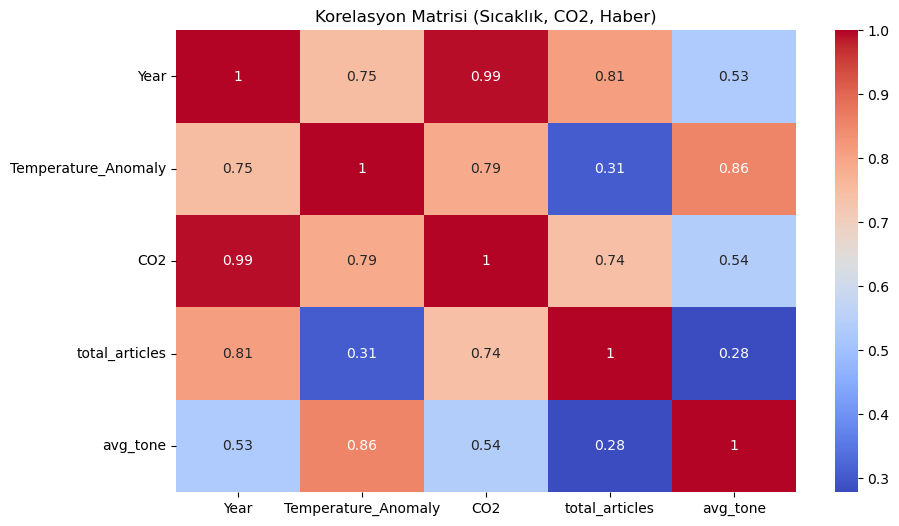

In [17]:
from pyspark.sql.functions import year, sum, avg

news_yearly = news_df.withColumn("Year", year("date")) \
    .groupBy("Year") \
    .agg(
        sum("article_count").alias("total_articles"),
        avg("avg_tone").alias("avg_tone")
    ) \
    .orderBy("Year")

# Sıcaklık ve CO2 ile birleştir
climate_news_df = climate_df.join(news_yearly, on="Year", how="inner")

# Pandas'a çevir
climate_news_pd = climate_news_df.toPandas()

# Korelasyon matrisi
print(climate_news_pd.corr())

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(climate_news_pd.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasyon Matrisi (Sıcaklık, CO2, Haber)')
plt.show()

Test RMSE: 10.37
Train R2: 1.00


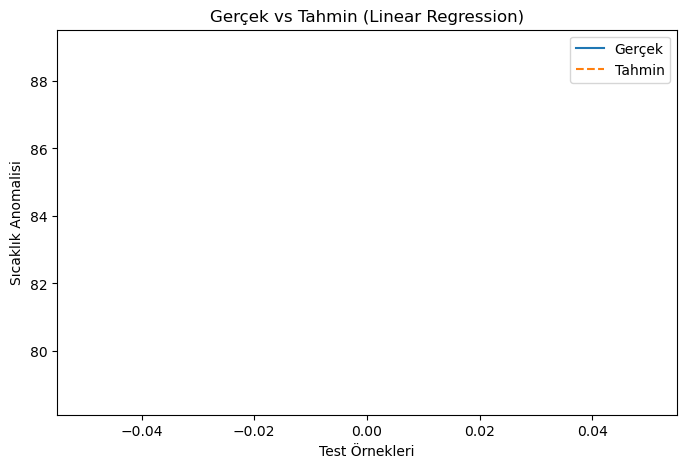

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Gerekli sütunları seç ve eksik verileri çıkar
ml_df = climate_news_df.select("CO2", "total_articles", "avg_tone", "Temperature_Anomaly").dropna()

# 2. Özellik vektörü oluştur
assembler = VectorAssembler(
    inputCols=["CO2", "total_articles", "avg_tone"],
    outputCol="features"
)
ml_df = assembler.transform(ml_df)

# 3. Train/Test böl
train_df, test_df = ml_df.randomSplit([0.8, 0.2], seed=42)

# 4. Modeli kur ve eğit
lr = LinearRegression(featuresCol="features", labelCol="Temperature_Anomaly")
lr_model = lr.fit(train_df)

# 5. Tahmin ve değerlendirme
predictions = lr_model.transform(test_df)
evaluator = RegressionEvaluator(
    labelCol="Temperature_Anomaly", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
r2 = lr_model.summary.r2

print(f"Test RMSE: {rmse:.2f}")
print(f"Train R2: {r2:.2f}")

# Gerçek ve tahmin edilen değerleri görselleştir
import matplotlib.pyplot as plt

pdf = predictions.select("Temperature_Anomaly", "prediction").toPandas()
plt.figure(figsize=(8,5))
plt.plot(pdf["Temperature_Anomaly"].values, label="Gerçek")
plt.plot(pdf["prediction"].values, label="Tahmin", linestyle="--")
plt.xlabel("Test Örnekleri")
plt.ylabel("Sıcaklık Anomalisi")
plt.title("Gerçek vs Tahmin (Linear Regression)")
plt.legend()
plt.show()

In [22]:
   print(pdf.shape)
   print(pdf)

(1, 2)
   Temperature_Anomaly  prediction
0                 89.0   78.627486
